Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import seaborn as sns
import pandas as pd
import joblib

Loading the dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.32MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.52MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Subset Creation for Classes 3 and 8

In [4]:
train_mask = torch.tensor([(target == 8 or target == 3) for target in trainset.targets])
test_mask = torch.tensor([(target == 8 or target == 3) for target in testset.targets])

trainset.data = trainset.data[train_mask]
trainset.targets = torch.tensor(trainset.targets)[train_mask]
testset.data = testset.data[test_mask]
testset.targets = torch.tensor(testset.targets)[test_mask]

<ipython-input-4-7678150fcea2>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset.targets = torch.tensor(trainset.targets)[train_mask]
<ipython-input-4-7678150fcea2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset.targets = torch.tensor(testset.targets)[test_mask]


Converting to binary (1-Digit 3, 0-Digit 8)

In [5]:
trainset.targets = torch.tensor([1 if target == 3 else 0 for target in trainset.targets])
testset.targets = torch.tensor([1 if target == 3 else 0 for target in testset.targets])

In [6]:
generator = torch.Generator().manual_seed(42)

Splitting the dataset into training, test and validation

In [7]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size],generator=generator)
print(len(train_dataset), len(val_dataset), len(testset))

9585 2397 1984


Class Distribution

Label
1    6131
0    5851
Name: count, dtype: int64


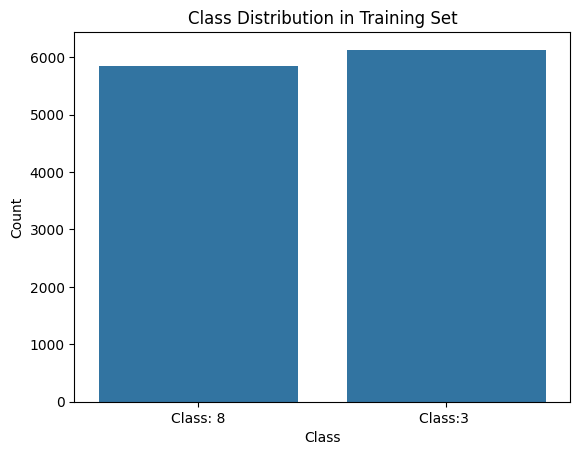

In [8]:
y_train = trainset.targets

df = pd.DataFrame({'Label': y_train})
print(df['Label'].value_counts())
sns.countplot(data=df, x='Label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([1, 0], ['Class:3 ', 'Class: 8'])
plt.show()

In [9]:
print(f"Image shape: {trainset.data[0].shape}")
print(f"Image data type: {trainset.data.dtype}")

Image shape: torch.Size([28, 28])
Image data type: torch.uint8


Displaying sample images

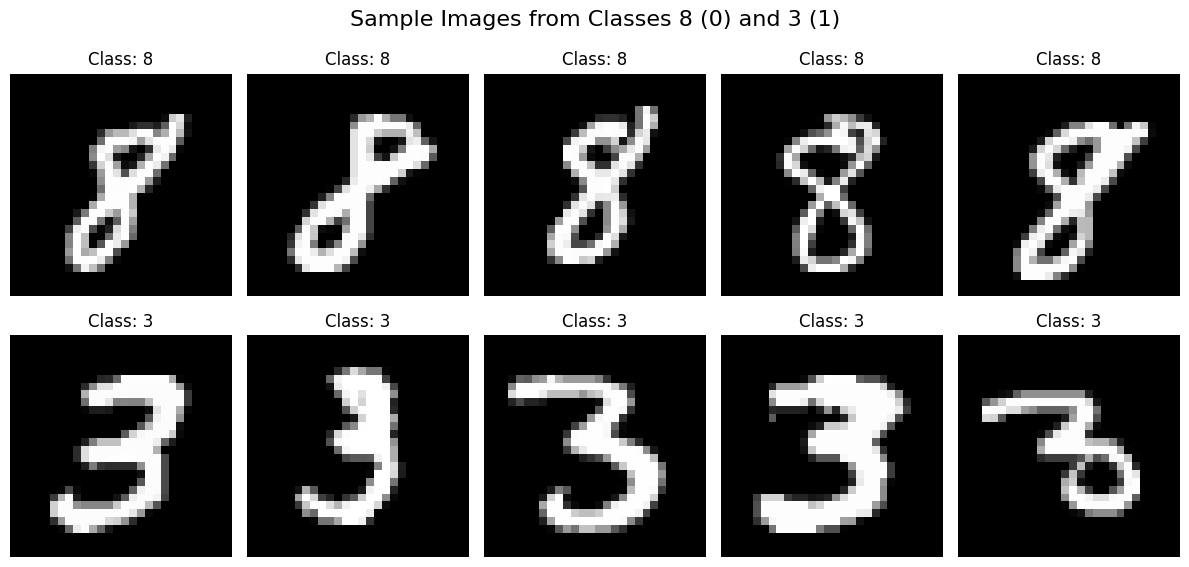

In [10]:
x_train = trainset.data.numpy()
y_train = trainset.targets.numpy()


fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample Images from Classes 8 (0) and 3 (1)', fontsize=16)
for i in range(5):
    axes[0, i].imshow(x_train[y_train == 0][i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title("Class: 8")
    axes[0, i].axis('off')
    axes[1, i].imshow(x_train[y_train == 1][i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title("Class: 3")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

Logistic Regression Without Regularization

In [11]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_dim, 1)
        nn.init.normal_(self.linear.weight, mean=0.0, std=1.0)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        x = self.flatten(x)
        outputs = torch.sigmoid(self.linear(x))
        return outputs

input_size = 784
learning_rate = 0.001
num_epochs = 30
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LogisticRegression(input_size).to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print('-' * 60)


Epoch [1/30], Loss: 10.1974
Training Loss: 9.4939, Training Accuracy: 47.04%
Validation Loss: 9.6402, Validation Accuracy: 48.94%
------------------------------------------------------------
Epoch [2/30], Loss: 12.2336
Training Loss: 10.1382, Training Accuracy: 48.87%
Validation Loss: 10.1477, Validation Accuracy: 52.19%
------------------------------------------------------------
Epoch [3/30], Loss: 9.9547
Training Loss: 9.8722, Training Accuracy: 51.99%
Validation Loss: 9.1112, Validation Accuracy: 54.40%
------------------------------------------------------------
Epoch [4/30], Loss: 12.1841
Training Loss: 8.8453, Training Accuracy: 54.48%
Validation Loss: 8.5710, Validation Accuracy: 56.95%
------------------------------------------------------------
Epoch [5/30], Loss: 5.3911
Training Loss: 8.1030, Training Accuracy: 57.22%
Validation Loss: 7.6548, Validation Accuracy: 59.41%
------------------------------------------------------------
Epoch [6/30], Loss: 4.9050
Training Loss: 7.2

Plotting loss and accuracy curves over epochs(Model Without Reg)

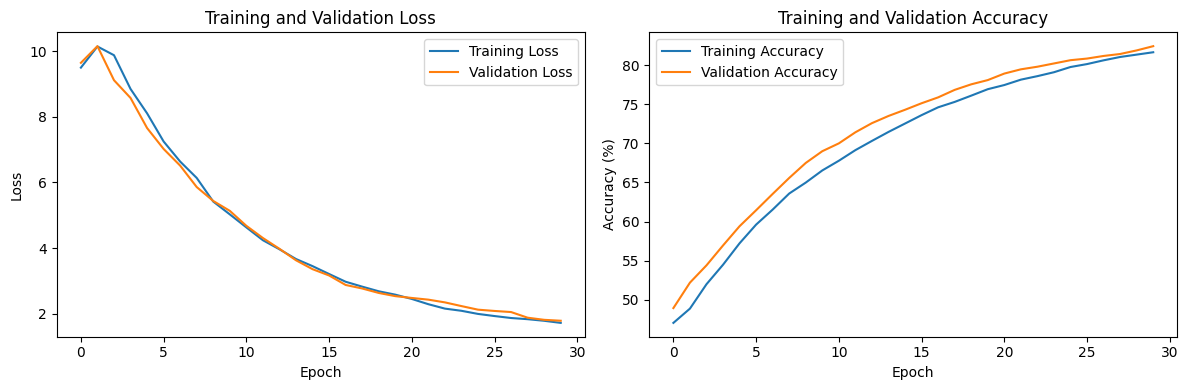

In [12]:
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Evaluation

In [13]:
# Evaluation on validation set
model.eval()
final_correct = 0
final_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = (outputs > 0.5).float()
        final_total += labels.size(0)
        final_correct += (predicted.squeeze() == labels).sum().item()

final_accuracy = 100 * final_correct / final_total
print(f'\nFinal Validation Accuracy: {final_accuracy:.2f}%')


Final Validation Accuracy: 82.44%


In [14]:
#Evaluation on test set
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
model.eval()
test_correct = 0
test_total = 0
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = (outputs > 0.5).float()
        test_total += labels.size(0)
        test_correct += (predicted.squeeze() == labels).sum().item()

        test_predictions.extend(predicted.squeeze().cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')



Test Accuracy: 83.57%


Logistic Regression With Regularization

In [15]:
class RegularizedLogisticRegression(nn.Module):
    def __init__(self, input_dim=784):
        super(RegularizedLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_dim, 1)
        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        x = self.flatten(x)
        return torch.sigmoid(self.linear(x))

    def l1_loss(self):
        return torch.norm(self.linear.weight, 1)

    def l2_loss(self):
        return torch.norm(self.linear.weight, 2)

learning_rate = 0.001
num_epochs = 30
batch_size = 64
lambda_l1 = 0.0001
lambda_l2 = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegularizedLogisticRegression().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.float().to(device)

        optimizer.zero_grad()
        output = model(data)

        bce_loss = criterion(output.squeeze(), target)
        reg_loss = lambda_l1 * model.l1_loss() + lambda_l2 * model.l2_loss()
        total_loss = bce_loss + reg_loss

        total_loss.backward()
        optimizer.step()

        predicted = (output.squeeze() > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()
        train_loss += total_loss.item()

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().to(device)
            output = model(data)
            val_loss += criterion(output.squeeze(), target).item()
            predicted = (output.squeeze() > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    print(f'Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100*val_correct/val_total:.2f}%')


Epoch [1/30]
Train Loss: 22.8736, Accuracy: 46.52%
Val Loss: 10.1408, Accuracy: 50.94%
Epoch [2/30]
Train Loss: 5.2007, Accuracy: 61.99%
Val Loss: 3.7747, Accuracy: 69.13%
Epoch [3/30]
Train Loss: 2.4253, Accuracy: 75.33%
Val Loss: 2.0316, Accuracy: 78.31%
Epoch [4/30]
Train Loss: 1.6337, Accuracy: 81.77%
Val Loss: 1.7737, Accuracy: 81.77%
Epoch [5/30]
Train Loss: 1.3493, Accuracy: 84.99%
Val Loss: 1.4339, Accuracy: 85.44%
Epoch [6/30]
Train Loss: 1.1433, Accuracy: 87.39%
Val Loss: 1.2754, Accuracy: 87.44%
Epoch [7/30]
Train Loss: 1.0087, Accuracy: 89.06%
Val Loss: 1.1918, Accuracy: 88.90%
Epoch [8/30]
Train Loss: 0.9392, Accuracy: 89.97%
Val Loss: 1.0611, Accuracy: 89.36%
Epoch [9/30]
Train Loss: 0.8506, Accuracy: 90.86%
Val Loss: 0.9311, Accuracy: 90.11%
Epoch [10/30]
Train Loss: 0.7796, Accuracy: 91.64%
Val Loss: 0.8951, Accuracy: 90.53%
Epoch [11/30]
Train Loss: 0.7246, Accuracy: 91.90%
Val Loss: 0.8554, Accuracy: 91.45%
Epoch [12/30]
Train Loss: 0.6654, Accuracy: 92.45%
Val Loss: 

Evaluation

In [17]:
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.float().to(device)
        output = model(data)

        # Calculating test loss including regularization
        bce_loss = criterion(output.squeeze(), target)
        reg_loss = lambda_l1 * model.l1_loss() + lambda_l2 * model.l2_loss()
        total_loss = bce_loss + reg_loss

        test_loss += total_loss.item()
        predicted = (output.squeeze() > 0.5).float()
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

        # Storing predictions for ROC curve
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(output.squeeze().cpu().numpy())

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Final Test Results:
Test Loss: 0.4524
Test Accuracy: 94.66%


Plotting loss and accuracy curves over epochs(Model With Reg)

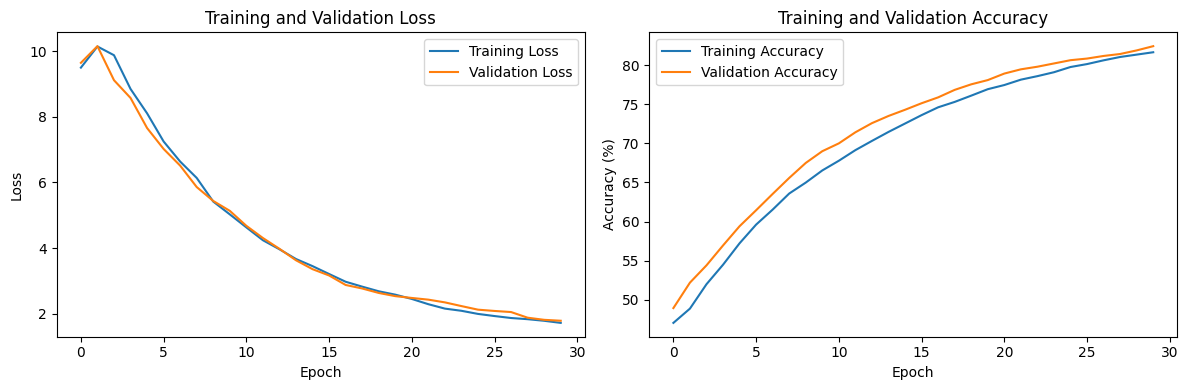

In [16]:
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

ROC Curve for Intitial Regularized Logistic Regression Model

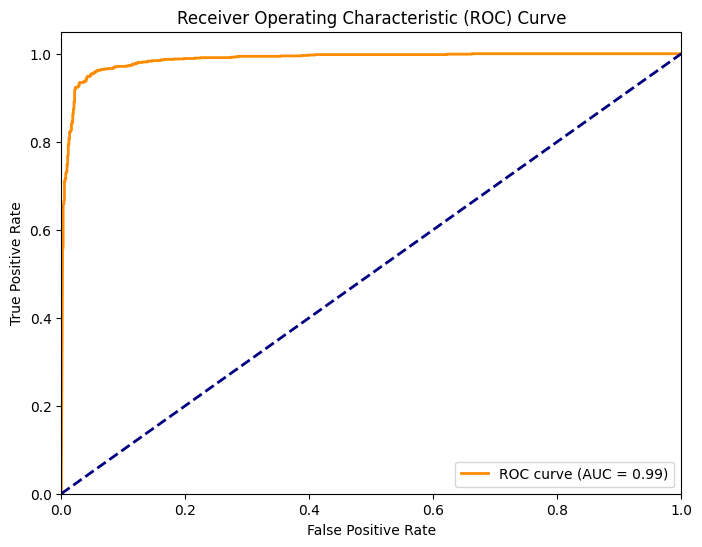

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Hyperparameter Tuning Using Manual Grid Search

In [18]:
# Defining parameter grid
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'lambda_l1': [0.0001, 0.001, 0.01],
    'lambda_l2': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128]
}

results = []

#  Manual Grid Search
for lr in param_grid['learning_rate']:
    for l1 in param_grid['lambda_l1']:
        for l2 in param_grid['lambda_l2']:
            for bs in param_grid['batch_size']:
                model = RegularizedLogisticRegression().to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

                # Training loop
                best_val_acc = 0

                for epoch in range(num_epochs):
                    model.train()
                    train_loss = 0
                    train_correct = 0
                    train_total = 0

                    for data, target in train_loader:
                        data, target = data.to(device), target.float().to(device)

                        optimizer.zero_grad()
                        output = model(data)

                        bce_loss = criterion(output.squeeze(), target)
                        reg_loss = l1 * model.l1_loss() + l2 * model.l2_loss()
                        total_loss = bce_loss + reg_loss

                        total_loss.backward()
                        optimizer.step()

                        predicted = (output.squeeze() > 0.5).float()
                        train_total += target.size(0)
                        train_correct += (predicted == target).sum().item()
                        train_loss += total_loss.item()

                    # Validation
                    model.eval()
                    val_correct = 0
                    val_total = 0

                    with torch.no_grad():
                        for data, target in val_loader:
                            data, target = data.to(device), target.float().to(device)
                            output = model(data)
                            predicted = (output.squeeze() > 0.5).float()
                            val_total += target.size(0)
                            val_correct += (predicted == target).sum().item()

                    val_acc = 100 * val_correct / val_total
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc

                # Storing results
                results.append({
                    'learning_rate': lr,
                    'lambda_l1': l1,
                    'lambda_l2': l2,
                    'batch_size': bs,
                    'val_accuracy': best_val_acc
                })

                print(f'Parameters: lr={lr}, l1={l1}, l2={l2}, bs={bs}')
                print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
                print('-' * 60)

Parameters: lr=0.0001, l1=0.0001, l2=0.0001, bs=32
Best Validation Accuracy: 86.40%
------------------------------------------------------------
Parameters: lr=0.0001, l1=0.0001, l2=0.0001, bs=64
Best Validation Accuracy: 80.77%
------------------------------------------------------------
Parameters: lr=0.0001, l1=0.0001, l2=0.0001, bs=128
Best Validation Accuracy: 73.34%
------------------------------------------------------------
Parameters: lr=0.0001, l1=0.0001, l2=0.001, bs=32
Best Validation Accuracy: 84.52%
------------------------------------------------------------
Parameters: lr=0.0001, l1=0.0001, l2=0.001, bs=64
Best Validation Accuracy: 82.64%
------------------------------------------------------------
Parameters: lr=0.0001, l1=0.0001, l2=0.001, bs=128
Best Validation Accuracy: 70.76%
------------------------------------------------------------
Parameters: lr=0.0001, l1=0.0001, l2=0.01, bs=32
Best Validation Accuracy: 85.02%
-------------------------------------------------

Best Parameters post tuning

In [19]:
best_result = max(results, key=lambda x: x['val_accuracy'])
print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Lambda L1: {best_result['lambda_l1']}")
print(f"Lambda L2: {best_result['lambda_l2']}")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Best Validation Accuracy: {best_result['val_accuracy']:.2f}%")


Best Hyperparameters:
Learning Rate: 0.01
Lambda L1: 0.001
Lambda L2: 0.001
Batch Size: 64
Best Validation Accuracy: 96.75%


Plotting Grid Search Results

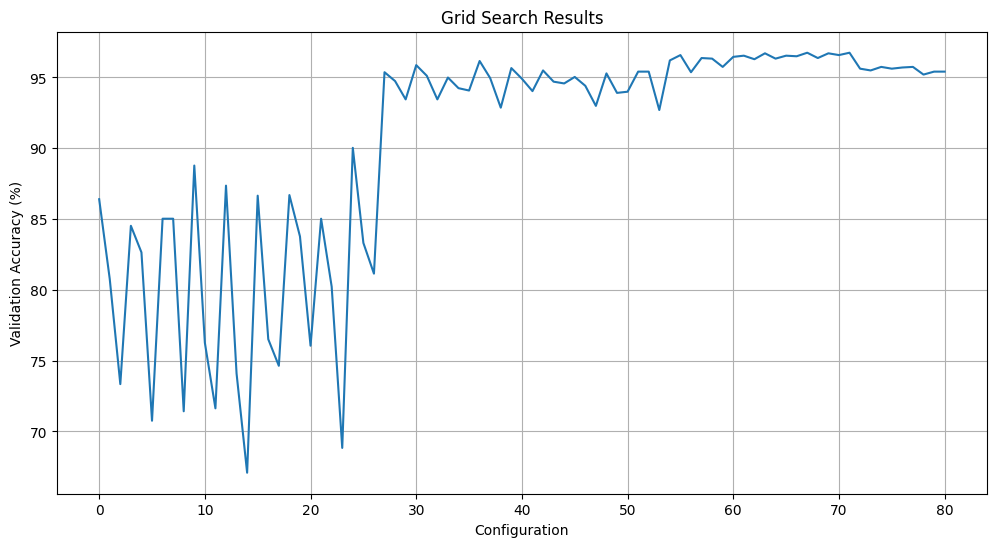

In [20]:
plt.figure(figsize=(12, 6))
plt.plot([r['val_accuracy'] for r in results])
plt.xlabel('Configuration')
plt.ylabel('Validation Accuracy (%)')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()

Training the model on best parameters

In [21]:
best_model = RegularizedLogisticRegression().to(device)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_result['learning_rate'])
criterion = nn.BCELoss()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    best_model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.float().to(device)

        best_optimizer.zero_grad()
        output = best_model(data)

        bce_loss = criterion(output.squeeze(), target)
        reg_loss = best_result['lambda_l1'] * best_model.l1_loss() + \
                  best_result['lambda_l2'] * best_model.l2_loss()
        total_loss = bce_loss + reg_loss

        total_loss.backward()
        best_optimizer.step()

        train_loss += total_loss.item()
        predicted = (output.squeeze() > 0.5).float()
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    train_losses.append(train_loss/len(train_loader))
    train_accs.append(100 * train_correct/train_total)

    # Validation phase
    best_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().to(device)

            output = best_model(data)
            bce_loss = criterion(output.squeeze(), target)
            reg_loss = best_result['lambda_l1'] * best_model.l1_loss() + \
                      best_result['lambda_l2'] * best_model.l2_loss()
            total_loss = bce_loss + reg_loss

            val_loss += total_loss.item()
            predicted = (output.squeeze() > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    val_losses.append(val_loss/len(val_loader))
    val_accs.append(100 * val_correct/val_total)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accs[-1]:.2f}%')
        print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.2f}%')
        print('-' * 60)


Epoch [5/30]:
Training Loss: 0.9574, Training Accuracy: 94.57%
Validation Loss: 0.9545, Validation Accuracy: 94.79%
------------------------------------------------------------
Epoch [10/30]:
Training Loss: 0.6811, Training Accuracy: 95.47%
Validation Loss: 0.7422, Validation Accuracy: 93.58%
------------------------------------------------------------
Epoch [15/30]:
Training Loss: 0.5095, Training Accuracy: 95.81%
Validation Loss: 0.4815, Validation Accuracy: 95.49%
------------------------------------------------------------
Epoch [20/30]:
Training Loss: 0.3930, Training Accuracy: 96.09%
Validation Loss: 0.3605, Validation Accuracy: 96.58%
------------------------------------------------------------
Epoch [25/30]:
Training Loss: 0.3132, Training Accuracy: 95.96%
Validation Loss: 0.2955, Validation Accuracy: 96.33%
------------------------------------------------------------
Epoch [30/30]:
Training Loss: 0.2681, Training Accuracy: 95.97%
Validation Loss: 0.2566, Validation Accuracy: 9

Evaluation on test set

In [22]:
test_loader = DataLoader(testset, batch_size=best_result['batch_size'], shuffle=False)
best_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.float().to(device)
        output = best_model(data)
        predicted = (output.squeeze() > 0.5).float()
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 96.27%


Plotting

Per Class Accuracy Function

In [23]:
def plot_per_class_accuracy(y_true, y_pred):
    class_names = ['Class 8', 'Class 3']
    accuracies = []

    for i in range(2):
        mask = (np.array(y_true) == i)
        class_acc = np.mean(np.array(y_pred)[mask] == i) * 100
        accuracies.append(class_acc)

    plt.figure(figsize=(8, 6))
    plt.bar(class_names, accuracies)
    plt.title('Per-Class Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.ylim([0, 100])
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 1, f'{acc:.1f}%', ha='center')
    plt.show()

    print("\nPer-class Accuracy:")
    for name, acc in zip(class_names, accuracies):
        print(f"{name}: {acc:.2f}%")

In [24]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            y_true.extend(target.cpu().numpy())
            y_pred.extend((output.squeeze() > 0.5).float().cpu().numpy())
            y_prob.extend(output.squeeze().cpu().numpy())

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    class_accuracies = []
    for i in range(2):
        mask = (np.array(y_true) == i)
        class_acc = np.mean(np.array(y_pred)[mask] == i) * 100
        class_accuracies.append(class_acc)

    return {
        'auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'tpr': tpr,
        'y_true': y_true,
        'y_pred': y_pred,
        'class_accuracies': class_accuracies
    }


In [25]:
def plot_results(train_losses, val_losses, train_accs, val_accs, metrics):
    plt.figure(figsize=(15, 5))

    # Plotting losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plotting ROC curve
    plt.subplot(1, 3, 3)
    plt.plot(metrics['fpr'], metrics['tpr'],
             label=f'ROC curve (AUC = {metrics["auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def create_results_table(metrics):
    results_dict = {
        'Metric': ['Overall Accuracy', 'AUC', 'Precision', 'Recall', 'F1 Score',
                  'Class 8 Accuracy', 'Class 3 Accuracy'],
        'Value': [np.mean(metrics['class_accuracies']),
                 metrics['auc'],
                 metrics['precision'],
                 metrics['recall'],
                 metrics['f1'],
                 metrics['class_accuracies'][0],
                 metrics['class_accuracies'][1]]
    }
    results_df = pd.DataFrame(results_dict)
    print("\nResults Summary:")
    print(results_df.to_string(index=False))

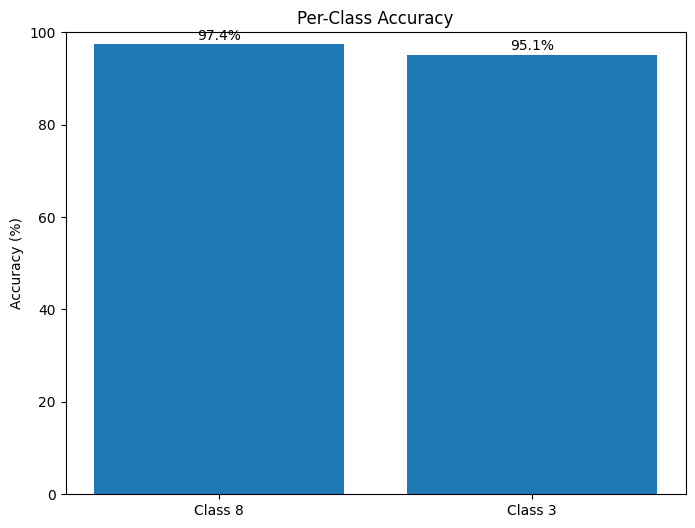


Per-class Accuracy:
Class 8: 97.43%
Class 3: 95.15%

Results Summary:
          Metric     Value
Overall Accuracy 96.290890
             AUC  0.992539
       Precision  0.974645
          Recall  0.951485
        F1 Score  0.962926
Class 8 Accuracy 97.433265
Class 3 Accuracy 95.148515


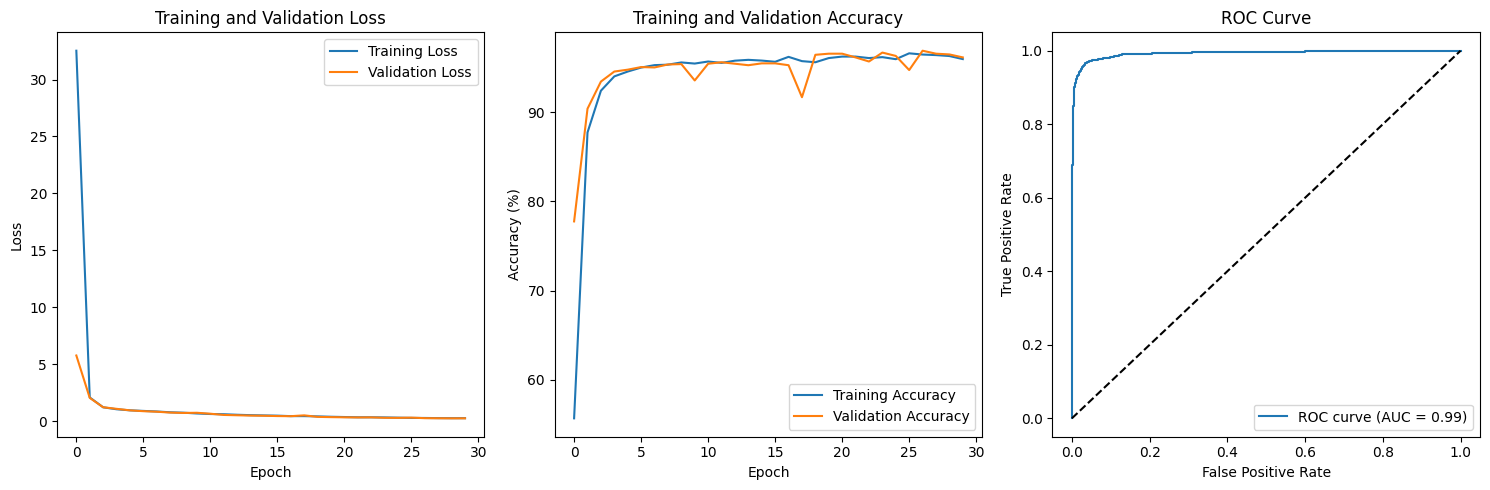

In [27]:
metrics = evaluate_model(best_model, test_loader)
plot_per_class_accuracy(metrics['y_true'], metrics['y_pred'])
create_results_table(metrics)
plot_results(train_losses, val_losses, train_accs, val_accs, metrics)

Plotting Accuracy vs Learning Rate

In [28]:
learning_rates = [0.0001, 0.001, 0.01]
lr_results = {}

for lr in learning_rates:
    model = RegularizedLogisticRegression().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lr_results[lr] = {'train_accs': [], 'test_accs': []}

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_correct = 0
        train_total = 0
        for data, target in train_loader:
            data, target = data.to(device), target.float().to(device)
            output = model(data)
            predicted = (output.squeeze() > 0.5).float()
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        train_acc = 100 * train_correct / train_total

        # Test accuracy
        test_correct = 0
        test_total = 0
        for data, target in test_loader:
            data, target = data.to(device), target.float().to(device)
            output = model(data)
            predicted = (output.squeeze() > 0.5).float()
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
        test_acc = 100 * test_correct / test_total

    lr_results[lr]['train_accs'].append(train_acc)
    lr_results[lr]['test_accs'].append(test_acc)

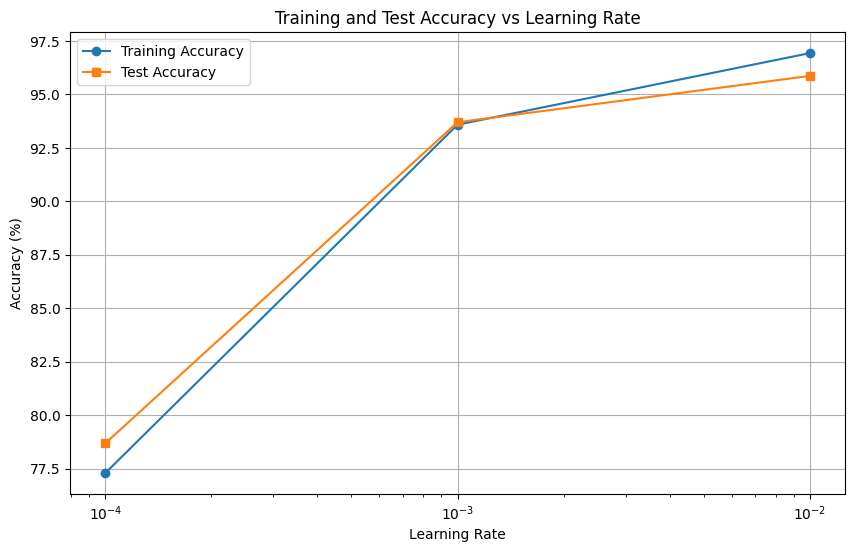

In [29]:
plt.figure(figsize=(10, 6))
lrs = list(lr_results.keys())
train_means = [np.mean(lr_results[lr]['train_accs']) for lr in lrs]
test_means = [np.mean(lr_results[lr]['test_accs']) for lr in lrs]

plt.plot(lrs, train_means, marker='o', label='Training Accuracy')
plt.plot(lrs, test_means, marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()


Plotting Accuracy vs Number of Samples

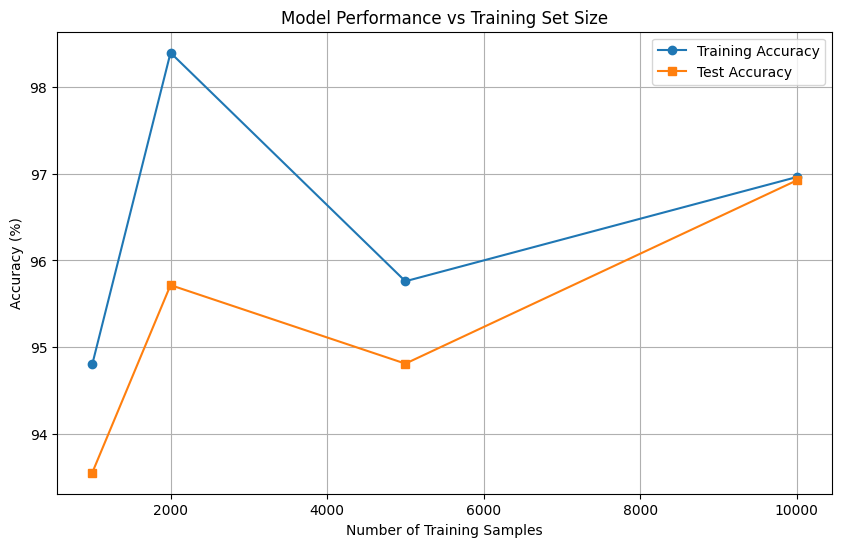

In [30]:
sample_sizes = [1000, 2000, 5000, 10000]
sample_results = {'train_accs': [], 'test_accs': []}

best_result = max(results, key=lambda x: x['val_accuracy'])

for n_samples in sample_sizes:
    indices = torch.randperm(len(train_dataset))[:n_samples]
    subset_train = torch.utils.data.Subset(train_dataset, indices)
    subset_loader = DataLoader(subset_train,
                             batch_size=best_result['batch_size'],
                             shuffle=True)

    model = RegularizedLogisticRegression().to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_result['learning_rate'])

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for data, target in subset_loader:
            data, target = data.to(device), target.float().to(device)

            optimizer.zero_grad()
            output = model(data)

            bce_loss = criterion(output.squeeze(), target)
            reg_loss = best_result['lambda_l1'] * model.l1_loss() + \
                      best_result['lambda_l2'] * model.l2_loss()
            total_loss = bce_loss + reg_loss

            total_loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_correct = 0
        train_total = 0
        for data, target in subset_loader:
            data, target = data.to(device), target.float().to(device)
            output = model(data)
            predicted = (output.squeeze() > 0.5).float()
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        train_acc = 100 * train_correct / train_total

        # Test accuracy
        test_correct = 0
        test_total = 0
        for data, target in test_loader:
            data, target = data.to(device), target.float().to(device)
            output = model(data)
            predicted = (output.squeeze() > 0.5).float()
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
        test_acc = 100 * test_correct / test_total

        sample_results['train_accs'].append(train_acc)
        sample_results['test_accs'].append(test_acc)

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, sample_results['train_accs'], marker='o', label='Training Accuracy')
plt.plot(sample_sizes, sample_results['test_accs'], marker='s', label='Test Accuracy')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs Training Set Size')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix

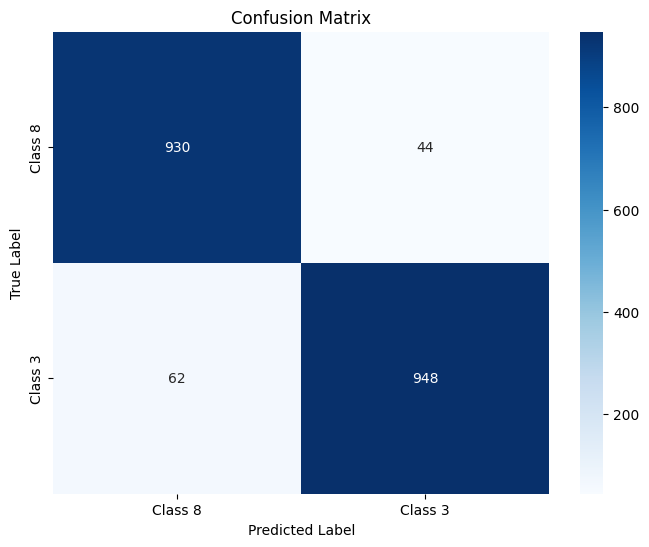

In [31]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 8', 'Class 3'],
            yticklabels=['Class 8', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Saving the model

In [32]:
joblib.dump(best_model, 'best_model_LR.joblib')

['best_model_LR.joblib']